My workflow was inspired by the TensorFlow tutorial on image classification - 
https://www.tensorflow.org/tutorials/images/classification

and the following kernel-
https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

Exploratory Data Analysis - 

We have a dataset of 220k training images and 57k test images. The dataset comes from the PCam dataset, which is images of lymph node sections that either contain tumors or do not. Our goal is the build a model that can accurate predict whether a test images has a tumor or does not.

Import tensorflow and other necessary libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from glob import glob
import os, cv2, shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Creating a df of the training data, with a column for path, a column for image id, and a column for label

In [2]:
train_dir = 'input/train/'
df = pd.DataFrame({'path': glob(os.path.join(train_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
labels = pd.read_csv("input/train_labels.csv")
df = df.merge(labels, on = 'id')
df.head(10)

,path,id,label
0,input/train\00001b2b5609af42ab0ab276dd4cd41c3e...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,input/train\000020de2aa6193f4c160e398a8edea95b...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,input/train\00004aab08381d25d315384d646f5ce413...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,input/train\0000d563d5cfafc4e68acb7c9829258a29...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,input/train\0000da768d06b879e5754c43e2298ce487...,0000da768d06b879e5754c43e2298ce48726f722,1
5,input/train\0000f8a4da4c286eee5cf1b0d2ab82f979...,0000f8a4da4c286eee5cf1b0d2ab82f979989f7b,0
6,input/train\00010f78ea8f878117500c445a658e5857...,00010f78ea8f878117500c445a658e5857f4e304,0
7,input/train\00011545a495817817c6943583b294c900...,00011545a495817817c6943583b294c900a137b8,0
8,input/train\000126ec42770c7568204e2f6e07eb9a07...,000126ec42770c7568204e2f6e07eb9a07d5e121,0
9,input/train\00014e39b5df5f80df56f18a0a049d1cc6...,00014e39b5df5f80df56f18a0a049d1cc6de430a,1


Creating two separate dfs for each label. This will allow me to use tf.keras.utils.image_dataset_from_directory which needs the images separated into different folders for each label to work. It also doesn't accept *.tif files, so creating some new folders and converting the images to .jpg

In [3]:
df1 = df[df['label'] == 1]
df0 = df[df['label'] == 0]

In [ ]:
new_path = "labeled/0/"

for index, row in df0.iterrows():
  shutil.copy(row['path'], new_path)
  
new_path = "labeled/1/"

for index, row in df1.iterrows():
  shutil.copy(row['path'], new_path)

In [ ]:
base_path = "labeled/0/"
new_path = "labeled/0j/"
for infile in os.listdir(base_path):
    print ("file : " + infile)
    read = cv2.imread(base_path + infile)
    outfile = infile.split('.')[0] + '.jpg'
    cv2.imwrite(new_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 100])
    
base_path = "labeled/1/"
new_path = "labeled/1j/"
for infile in os.listdir(base_path):
    print ("file : " + infile)
    read = cv2.imread(base_path + infile)
    outfile = infile.split('.')[0] + '.jpg'
    cv2.imwrite(new_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 100])

Splitting my training data into a training set and validation set

In [4]:
train_dir = 'labeled/'

batch_size = 32
img_height = 96
img_width = 96

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


Showing the class names

In [6]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


Visualizing the data -
 


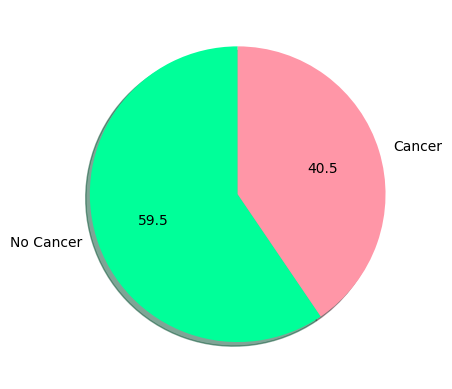

<Figure size 1600x1600 with 0 Axes>

In [6]:
labels_count = df['label'].value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=90, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

So we have 40k more images of non tumor containing images

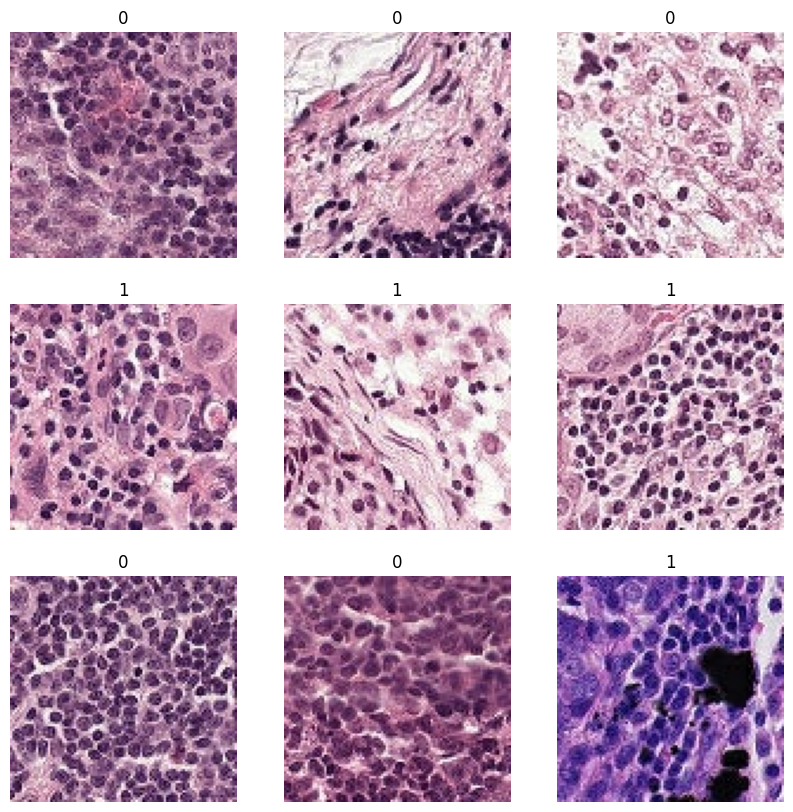

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Looking at the images, it's clear that an untrained human would have a very hard time differentiating between an image from class 1 and one from class 0. Even for a trained professional, this would likely be a very time consuming task.

Based on the EDA, I don't see the need to alter the dataset in any way. I plan on creating a Keras sequential model, training on the 80% of the training data, with 20% being used as validation. From there I can make predictions of the test set from my trained CNN model. 

Configuring the dataset for performance. Cache keeps the images in memory after they are loaded from the disk, and prefetch overlaps data preprocessing and model executing while training. These together will help the model run more efficiently

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the Keras model. Using a simple model with [Conv-Conv-MaxPool]n structure. Three convolution blocks, dropout regularization. Sigmoid activation function in the dense layer since my problem is binary.

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3,3), padding='same', input_shape = (96, 96, 3), activation='relu'),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Dropout(0.2),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

Compiling the model with Adam optimizer and 0.001 learning rate.

In [10]:
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        4640      
                                                        

In [12]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
5501/5501 [==============================] - 918s 163ms/step - loss: 0.4093 - accuracy: 0.8166 - val_loss: 0.3199 - val_accuracy: 0.8637
Epoch 2/5
5501/5501 [==============================] - 811s 147ms/step - loss: 0.3088 - accuracy: 0.8684 - val_loss: 0.2719 - val_accuracy: 0.8843
Epoch 3/5
5501/5501 [==============================] - 791s 144ms/step - loss: 0.2702 - accuracy: 0.8886 - val_loss: 0.2606 - val_accuracy: 0.8937
Epoch 4/5
5501/5501 [==============================] - 791s 144ms/step - loss: 0.2485 - accuracy: 0.8995 - val_loss: 0.2480 - val_accuracy: 0.9014
Epoch 5/5
5501/5501 [==============================] - 791s 144ms/step - loss: 0.2328 - accuracy: 0.9068 - val_loss: 0.2042 - val_accuracy: 0.9226


Plotting the accuracy and loss on the training and validation sets

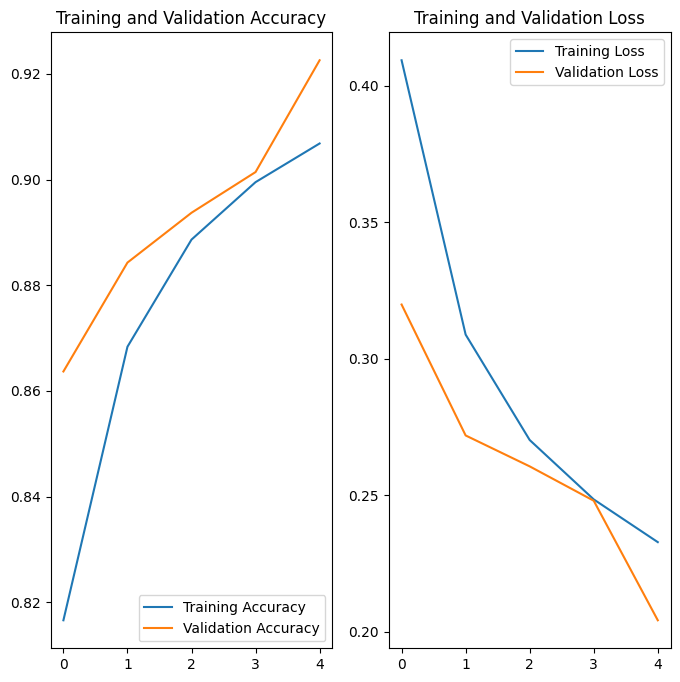

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy and loss look good for the model. If the accuracy was poor or the difference between the training and validation sets were much larger, I would suspect over fitting, and potentially adjust the model. But I already included dropout, and it seems to be working.

Now I have to convert the test images to *.jpg and create a test dataset to predict the labels of.

In [ ]:
base_path = "input/test/"
new_path = "test_J/"
for infile in os.listdir(base_path):
    print ("file : " + infile)
    read = cv2.imread(base_path + infile)
    outfile = infile.split('.')[0] + '.jpg'
    cv2.imwrite(new_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [15]:
test_dir = 'test_J/'

batch_size = 32
img_height = 96
img_width = 96

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels=None,
  shuffle=False
)

Found 57458 files belonging to 1 classes.


Now we can use the model to predict the test data set 

In [16]:
predictions = model.predict(test_ds)

1796/1796 [==============================] - 80s 44ms/step


In [17]:
test_dir = 'input/test/'
test_files = glob(os.path.join(test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
max_idx = len(test_files) #last index to use

print("Indexes: %i - %i"%(0, max_idx))
test_df = pd.DataFrame({'path': test_files[0:max_idx]}) #add the filenames to the dataframe
test_df['id'] = test_df.path.map(lambda x: x.split('\\')[1].split(".")[0]) #add the ids to the dataframe
test_df['image'] = test_df['path'].map(cv2.imread) #read the images

for idx in range(0, max_idx): #iterate over test images
    score = tf.nn.sigmoid(predictions[idx]) 
    class_label = class_names[np.argmax(score)]
    test_df.loc[idx, 'label'] = class_label #add label to the dataframe
    
submission = pd.concat([submission, test_df[["id", "label"]]]) #add results to dataframe
submission.head() #display first lines

Indexes: 0 - 57458


C:\Users\Ryzen 5 5600X\AppData\Local\Temp\ipykernel_24664\1230468629.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df.loc[idx, 'label'] = class_label #add label to the dataframe


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [18]:
submission.to_csv("submission.csv", index = False, header= True) #create the submission file

After submitting to the competition, I have a score of 0.8573 with this model. I submitted 4 different models, and this was the best result I received. A breakdown of the models is below

CNN - 5 epochs - Dropout layers / Pooling layers       --  0.8573
CNN - 3 epochs - Dropout layers / Pooling layers       --  0.829
CNN - 3 epochs - No dropout/pooling                    --  0.6828
CNN - 3 epochs - test data shuffle not accounted for   --  0.5023

My first submission I knew something was drastically wrong, as I barely cracked fifty percent accuracy. Upon inspection, I realized that tf.keras.utils.image_dataset_from_directory actually shuffles your images by default, so when I was making my predictions, I was not labeling the correct images. Luckily this was easily remedied with one line of code. Fixing this increased my accuracy, but still not to a great level. But I had left dropout and pooling layers out. Adding these in again increased my accuracy, and at this point I was happy with the model. I just increased the number of epochs one last time for my final submission.

I think moving forward, adding even more epochs (10) would be worthwhile. I did not have the use of GPUs for this project, so my models were taking a long time to train, and 10 epochs was not feasible. I also would like to play around with the learning rate and see how it affected things, but again, the time it would have taken to see these was too much. 

My GitHub repository can be foudn here - 
https://www.tensorflow.org/tutorials/images/classification
